# Handwritten Text Recognition System

## Problem Definition

Our application aims to facilitate the conversion of handwritten text into digital format. Users can upload images containing handwritten English block letters, including both uppercase and lowercase letters, as well as numeric digits. With a character set of 62 possibilities, spanning from 0-9, A-Z, and a-z, our goal is to accurately transcribe users' handwritten characters into textual characters.

This application targets a broad audience, including students, educators, researchers, and office workers. These users frequently engage in handwritten note-taking activities, and our application aims to streamline their workflow by allowing them to easily digitize their handwritten notes. This not only enhances organization but also facilitates the seamless integration of handwritten content into digital platforms.

Our application prioritizes simplicity and efficiency. Users expect minimal effort and swift results, thus emphasizing the need for low latency and user-friendly interfaces. 

## System Design

Our system consists of several key components:

- **Data Preprocessing:** We preprocess handwritten images, converting them into a suitable format for model training.Data preprocessing involves transforming uploaded images into a format suitable for the machine learning model. This includes resizing, grayscale conversion, and thresholding to enhance image quality.
- **Modeling:** We design and train a CNN architecture using PyTorch to perform the handwritten text recognition task. Model is trained on a dataset containing handwritten characters, the model learns to accurately classify images into their corresponding textual characters.
- **Deployment:** The trained model can be deployed for inference on new handwritten images. The user interface provides a seamless experience for users to upload images and receive digital text outputs. Minimalistic design and intuitive interactions ensure ease of use for users of all backgrounds.
- **User Experience:** We provide a simple interface for users to interact with the system, allowing them to upload images for text recognition.

Central design decisions include the choice of implementing CNN model for its effectiveness in image classification tasks and the utilization of PyTorch due to its flexibility and ease of use in implementing neural networks.

## Machine Learning Component

The CNN model is trained on a custom dataset comprising handwritten characters. We preprocess the images by resizing them, converting to grayscale, and applying thresholding to create binary images. The model architecture consists of multiple convolutional layers followed by fully connected layers. We optimize the model using the Adam optimizer and experiment with varying hyperparameters to improve performance.

## System Evaluation

We evaluate the system's performance by measuring accuracy on a separate test dataset. Additionally, we analyze training and validation loss to assess model convergence and potential overfitting. Our results demonstrate consistent improvement in accuracy over epochs, indicating the effectiveness of the proposed approach. However, we note that execution time increases with model complexity, highlighting a trade-off between performance and efficiency.

## Application Demonstration

To demonstrate the application, users can upload images containing handwritten text, and the system will provide the transcribed text. The interface is intuitive and user-friendly, allowing seamless interaction with the text recognition functionality. Detailed instructions on using the application are provided to ensure a smooth user experience.

## Reflection

Throughout the project, we encountered both successes and challenges. The CNN model proved effective in recognizing handwritten text, demonstrating steady improvement in accuracy. However, optimizing hyperparameters and managing execution time were ongoing challenges. In the future, we plan to explore more advanced architectures and optimization techniques to further enhance performance.

## Broader Impacts

Our application has potential uses in various domains, including digitization of handwritten documents and aiding individuals with disabilities. However, we recognize the importance of mitigating unintended uses and potential biases in the system. We remain committed to ethical design practices and continual improvement to minimize harm and maximize societal benefit.

## References

- Streamlit Documentation:https://mafda.medium.com/prototyping-a-ml-app-with-streamlit-fastapi-hugging-face-f21f14e7d239
- Convolutional Neural Networks Tutorial:https://github.com/zademn/mnist-mlops-learning
- Kaggle Handwritten Datasets: https://www.kaggle.com/code/mohammadkumail/handwritten-character-recognition-deep-learning
- ChatGPT 3.5


## Model Objectives:
* Starting with a simple model, try creating a more advanced CNN model that can be easily tuned
* Create models with varying depth (number of convolutional layers) to observe performance vs time consumption
* Apply various hyperparameter tuning techniques to CNN models

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import Normalize, ToTensor
import torch.nn as nn  # neural network
import torch.optim as optim  # optimization layer
import torch.nn.functional as F  # activation functions
import matplotlib.pyplot as plt
import argparse
import time
from collections import OrderedDict

In [89]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data_dir, csv_file, transform=None):
        self.data_dir = data_dir
        self.data_df = pd.read_csv(csv_file)
        self.transform = transform
        self.label_mapping = {label: index for index, label in enumerate("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")}

        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.data_df.iloc[idx, 0])
        image = Image.open(img_name)
        label_str = self.data_df.iloc[idx, 1]
        label = self.label_mapping[label_str]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)

class ToBinary(object):
    """
    Convert a grayscale image to a binary image using thresholding.

    Args:
    - threshold: Threshold value for binarization (default: 128)
    """
    def __init__(self, threshold=128):
        self.threshold = threshold

    def __call__(self, img):
        """
        Apply the transform to the input image.

        Args:
        - img: Input grayscale image (PIL Image or tensor)

        Returns:
        - bin_img: Binary image (PIL Image or tensor)
        """
        if isinstance(img, torch.Tensor):
            # Convert tensor to PIL Image
            img = transforms.ToPILImage()(img)

        # Convert the image to grayscale (if not already)
        if img.mode != 'L':
            img = img.convert('L')

        # Apply thresholding to convert to binary image
        bin_img = img.point(lambda p: p > self.threshold and 255)

        if isinstance(img, torch.Tensor):
            # Convert PIL Image to tensor
            bin_img = transforms.ToTensor()(bin_img)

        return bin_img

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 62)  # 62 classes for EMNIST ByClass dataset

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        # print(x.shape)
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize your CNN model
model = CNN()

In [94]:
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define transforms for the dataset
data_transform = transforms.Compose([
    transforms.Resize((32, 32)),    # Resize images to (32, 32)
    transforms.Grayscale(), # Convert images to grayscale
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    ToBinary(threshold=128),        # Convert images to binary using thresholding
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

# Create a custom dataset and dataloader
dataset = CustomDataset(data_dir='data/',
                        csv_file='data/english.csv',
                        transform=data_transform)

# Split dataset into train and test partitions
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders for train and test partitions
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 5
device = torch.device("cpu")
model.to(device)
model_path = '/Users/smritikumari/Desktop/ML_Project/hand_dataset_model/model.pt'

# model.load_state_dict(torch.load(model_path))

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    print(f"Training Loss: {epoch_loss:.4f}")

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", unit="batch"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")
torch.save(model.to(torch.device('cpu')).state_dict(), '/Users/smritikumari/Desktop/ML_Project/hand_dataset_model/model_binary.pt')

Epoch 1/5: 100%|██████████| 88/88 [00:32<00:00,  2.73batch/s]


Training Loss: 0.1647


Testing: 100%|██████████| 22/22 [00:07<00:00,  2.92batch/s]


Accuracy on test set: 0.9157


Epoch 2/5: 100%|██████████| 88/88 [00:32<00:00,  2.74batch/s]


Training Loss: 0.1059


Testing: 100%|██████████| 22/22 [00:07<00:00,  2.92batch/s]


Accuracy on test set: 0.9586


Epoch 3/5: 100%|██████████| 88/88 [00:32<00:00,  2.73batch/s]


Training Loss: 0.0602


Testing: 100%|██████████| 22/22 [00:07<00:00,  2.92batch/s]


Accuracy on test set: 0.9714


Epoch 4/5: 100%|██████████| 88/88 [00:32<00:00,  2.74batch/s]


Training Loss: 0.0423


Testing: 100%|██████████| 22/22 [00:07<00:00,  2.93batch/s]


Accuracy on test set: 0.9571


Epoch 5/5: 100%|██████████| 88/88 [00:32<00:00,  2.73batch/s]


Training Loss: 0.0301


Testing: 100%|██████████| 22/22 [00:07<00:00,  2.92batch/s]

Accuracy on test set: 0.9714


In [138]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os 

# def emnist_byclass_label_to_char(label):
#     if label < 10:
#         return str(label)  # Digits 0-9
#     elif label < 36:
#         return chr(label + 55)  # Capital letters A-Z (ASCII 65-90)
#     else:
#         return chr(label + 61)  # Small letters a-z (ASCII 97-122)

def emnist_byclass_label_to_char(label):
        # Decode label using the label mapping
    label_mapping = {label: index for index, label in enumerate("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")}
    return list(label_mapping.keys())[list(label_mapping.values()).index(label)]

def infer(net, test_folder):
    '''
    Returns test accuracy
    
        Parameters:
            net (CNN): a trained model
            args (ArgumentParser): hyperparameters
        
        Returns:
            test_acc (float): test accuracy of a trained model
    '''

    # net = CNN()
    
    # net.load_state_dict(torch.load(model_path))
    
    net.eval()

    def predict_image(image_path, model):
        image = Image.open(image_path)  # Convert to grayscale
        # Define transforms for the dataset
        transform = transforms.Compose([
            transforms.Resize((32, 32)),    # Resize images to (32, 32)
            transforms.Grayscale(),         # Convert images to grayscale
            ToBinary(threshold=128),        # Convert images to binary using thresholding
            transforms.ToTensor()           # Convert images to PyTorch tensors
        ])
        image = transform(image)
        image = torch.unsqueeze(image, 0)  # Add batch dimension
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            return predicted.item()


    # Iterate through each image in the folder
    for filename in os.listdir(test_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(test_folder, filename)
            predicted_label = predict_image(image_path, net)
            predicted_char = emnist_byclass_label_to_char(predicted_label)
            print(f"you wrote: for {filename}: {predicted_char}")

In [145]:
#Test inference code
model_path = '/Users/smritikumari/Desktop/ML_Project/hand_dataset_model/model.pt'
test_folder = '/Users/smritikumari/Desktop/ML_Project/hand_dataset_model/test_imgs/'
infer(model, test_folder)

you wrote: for h.png: h
you wrote: for i.png: i
you wrote: for Z.png: Z
you wrote: for AA.png: h
you wrote: for O.png: O
you wrote: for test A.png: R
you wrote: for PP.png: H
you wrote: for B.png: f
you wrote: for C.png: C
you wrote: for BB.png: K
you wrote: for 5.png: 5
you wrote: for A.png: A
you wrote: for w.png: d
you wrote: for 6.png: E
you wrote: for D.png: B
you wrote: for 2.png: 2
you wrote: for s.png: E
you wrote: for e.png: R
you wrote: for g.png: 5
you wrote: for P.png: F
you wrote: for CC.png: G
you wrote: for Q.png: d
you wrote: for f.png: f


Recognized Text: C0ZN


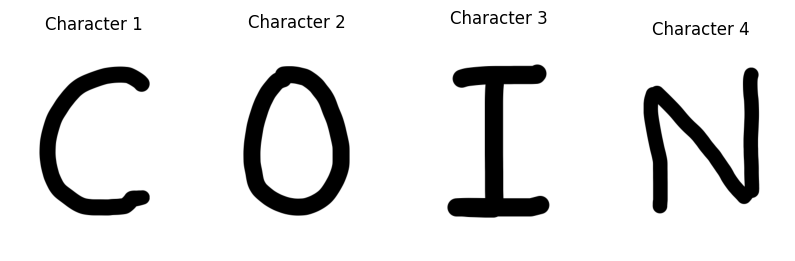

In [144]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

def crop_pillow_image(image, bounding_boxes, padding=60):
    """
    Crop a Pillow image based on the given list of bounding box coordinates and pad with white pixels.

    Args:
    - image: Pillow image object
    - bounding_boxes: List of bounding box coordinates (each bounding box is a tuple (x, y, w, h))
    - padding: Amount of padding to add around the bounding box (default: 10 pixels)

    Returns:
    - cropped_images: List of cropped and padded Pillow image objects
    """
    cropped_images = []
    for bbox in bounding_boxes:
        x, y, w, h = bbox
        # Crop the image using the provided coordinates
        cropped_image = image.crop((x, y, x + w, y + h))
        # Create a larger canvas with white background
        padded_image = Image.new('L', (w + 2 * padding, h + 2 * padding), color=255)
        # Paste the cropped image onto the canvas with an offset
        padded_image.paste(cropped_image, (padding, padding))
        # padded_image.show()
        cropped_images.append(padded_image)
    return cropped_images

def preprocess_image(image_path):
    
    orig_img = Image.open(image_path)
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply thresholding to get binary image
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    img = cv2.bitwise_not(img)
    # Find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Extract bounding boxes of contours
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    # Sort bounding boxes by x-coordinate to get characters from left to right
    bounding_boxes.sort(key=lambda x: x[0])
    # Extract individual characters
    characters = []
    # for x, y, w, h in bounding_boxes:
    #     character = img[y:y+h, x:x+w]
    #     characters.append(Image.fromarray(character)

    return crop_pillow_image(orig_img, bounding_boxes)

def infer_characters(characters):
    '''
    Returns test accuracy
    
        Parameters:
            net (CNN): a trained model
            args (ArgumentParser): hyperparameters
        
        Returns:
            test_acc (float): test accuracy of a trained model
    '''

    model.load_state_dict(torch.load('model.pt'))
    model.eval()

    def predict_image(image, model):
        # Define transforms for the dataset
        transform = transforms.Compose([
            transforms.Resize((32, 32)),    # Resize images to (32, 32)
            transforms.Grayscale(),         # Convert images to grayscale
            # ToBinary(threshold=128),        # Convert images to binary using thresholding
            transforms.ToTensor()           # Convert images to PyTorch tensors
        ])
        image = transform(image)
        image = torch.unsqueeze(image, 0)  # Add batch dimension
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            return predicted.item()
    
    predicted_chars = []
    # Iterate through each image in the folder
    for character in characters:
        predicted_label = predict_image(character, model)
        predicted_char = emnist_byclass_label_to_char(predicted_label)
        predicted_chars.append(predicted_char)
    
    return predicted_chars


def recognize_text(image_path):

    # Preprocess the image
    characters = preprocess_image(image_path)
    # Convert the predictions to text
    predicted_chars = infer_characters(characters)
    return ''.join(predicted_chars), characters

# Provide the path to your input image
input_image_path = 'test_imgs/Words/COIN.png'
# Recognize the text in the image
recognized_text, original_characters = recognize_text(input_image_path)

print("Recognized Text:", recognized_text)

# Plot the characters for visual inspection
plt.figure(figsize=(10, 5))
for i, character in enumerate(original_characters, 1):
    plt.subplot(1, len(original_characters), i)
    plt.imshow(character, cmap='gray')
    plt.title('Character {}'.format(i))
    plt.axis('off')
plt.show()

